# Creating a Machine Leaning Potential (MLP)

This note book will walk through creating a simple MLP from scratch. For simplicity it will be fitted to a 2D Lennard Jones system

## Making a descriptor

Feeding Atomic coordinates directly into a neural network (NN) is not going to work very well. We need to make a description of the local atomic environment that is *invariant* (more sophisticated models are also *equivariant*)

Invariant means that If the atomic configuration is rotated or displaced then the energy will be the same. MM forcefields are invariant. 

An invariant description of an atomic configuration can be built by considering the relative distances between the atoms. A NN takes a finite set of inputs, for our models to work with different number of neighbor atoms then the descriptors needs to be independent of the number of neighbors. To do this we project the local neighborhood density of an atom onto a radial basis.

Mathematically we can write this as 

$ B_{in} = \sum_j  R(r_{ij})_n $

$B_{in}$ is a 2D tensor of size $(N_{atoms}, N_{basis functions})$. The $i$ index corresponds to each atom. The $n$ index corresponds to the radial basis. 
$R(r)_n$ is a function that takes a distance $r$ and maps it onto a 1D Tensor of size $(N_{basis functions})$.
The sum is over all $j$ neighbors of atom $i$.
i.e. each row $i$ of the tensor $B$ contains the description of atom $i$ local environment encoded into the radial basis.

There are different options available, one of the simplest is Gaussian functions.

$R(r)_n = exp(-(r - e_n)^2/w)f(r) $

$e_n$ is a set of values e.g. $[e_0,e_1 .. , r_{cutoff}]$, $f(r)$ is an envelope function that is zero at $r_{cutoff}$ and makes the derivative at $r_{cutoff}$ continuous. 


An example is shown in the code below.

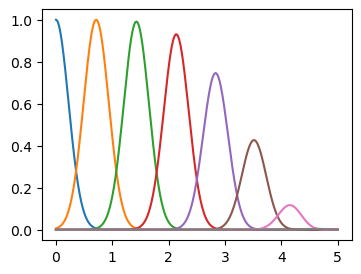

In [2]:
import torch
import matplotlib.pyplot as plt 

NB = 8
w = 0.1
r_cutoff = 5.0

def f(x):
    return( 1 - 28*x**6 + 48*x**7 - 21*x**8 )

xx=torch.linspace(0, r_cutoff, 1000)
en = torch.linspace(0,r_cutoff, NB)

plt.figure(figsize=(4,3))
for e in en:
    y = torch.exp(-(xx-e)**2/w)*f(xx/r_cutoff)
    plt.plot(xx,y)

plt.show()

# Projecting the atomic neighbors onto the radial basis

Lets generate some random coordinates, and get the radial basis descriptor for one of the atoms

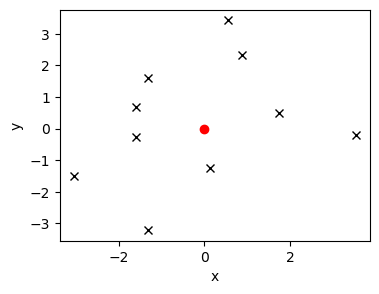

B0n: tensor([4.7416e-11, 1.0550e-03, 8.6900e-01, 1.1383e-01, 1.1556e+00, 2.1521e-01,
        6.5883e-02, 1.2401e-03])


In [3]:
import numpy as np

NATOMS=10

torch.manual_seed(1)
x=torch.randn(NATOMS,2)*2

def envelope(x):
    return( 1 - 28*x**6 + 48*x**7 - 21*x**8 )

def radial_basis(r,en, w, r_cutoff):
    f=envelope(r/r_cutoff)
    Bjn = torch.exp(-(r[:,None] - en[None,:])**2/w)*f[:,None]
    Bn = torch.sum(Bjn, dim=0)
    return Bn

# make a central atom at (0,0) and compute the distances
xi = torch.tensor([[0,0]])
d = xi-x
r = torch.sum(d**2, dim=1)

# plot the coords
plt.figure(figsize=(4,3))
plt.plot(x[:,0], x[:,1],'kx')
plt.plot(xi[0,0], xi[0,1],'ro')
plt.xlabel("x")
plt.ylabel("y")
plt.show()

NB = 8
w = 0.1
r_cutoff = 5.0
en = torch.linspace(0,r_cutoff, NB)
Bin = radial_basis(r,en,w,r_cutoff)

# Print the radial basis tensor for atom i=0
print("B0n:", Bin)


We can plot what this descriptor means, i.e. what the atoms sees:

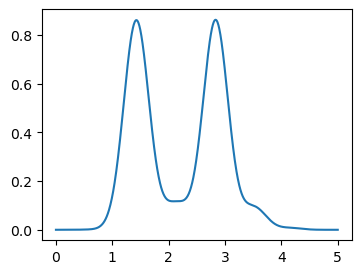

In [4]:

plt.figure(figsize=(4,3))
xx=torch.linspace(0, r_cutoff, 1000)
ys=[]
for n,e in enumerate(en):
    y = Bin[n]*torch.exp(-(xx-e)**2/w)*envelope(xx/r_cutoff)
    y=y.numpy()
    ys.append(y)
    
ys=np.sum(np.array(ys),axis=0)
plt.plot(xx,ys)
plt.show()


## Making a Neural Network

We can use a very basic standard neural network example.

there are two hidden layers which each have 16 features, and one output layer. The only thing we need to be careful about is that our activation functions should have smooth derivatives so we use SiLU instead of the common ReLU


In [5]:
class NNP(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # in the constructor we define the structure of the NN
        self.NN = torch.nn.Sequential(
            torch.nn.Linear(NB, 16),
            torch.nn.SiLU(),
            torch.nn.Linear(16, 16),
            torch.nn.SiLU(),
            torch.nn.Linear(16, 1),
        )

    def forward(self, B):
        
        # in the forward method we tell the NNP what to do when data is passed into it
        E = self.NN(B)

        return E
    
model = NNP()
print(model)

NNP(
  (NN): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): SiLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): SiLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)


We can now run our descriptor through the NNP. The model weights are randomly initialised so this will give us some output

In [6]:
prediction = model(Bin)
print(prediction)

tensor([-0.0081], grad_fn=<AddBackward0>)


Now lets compute the actual energy for this atomic configuration

In [7]:
def energy(r):
    sigma=1.0
    epsilon=2.0
    c6 = (sigma**2 / r**2)**3
    c12 = c6**2
    return torch.sum(4 * epsilon * (c12 - c6))


E = energy(r)
print(E)

tensor(-0.5960)


Now we can define the loss function and run a loop to minimize it

loss =  0.34567755460739136
loss =  0.3266482353210449
loss =  0.30868643522262573
loss =  0.29172852635383606
loss =  0.2757151126861572
loss =  0.2605908513069153
loss =  0.24630394577980042
loss =  0.23280611634254456
loss =  0.22005212306976318
loss =  0.20799952745437622
loss =  0.19660866260528564
loss =  0.18584218621253967
loss =  0.17566511034965515
loss =  0.16604448854923248
loss =  0.15694943070411682
loss =  0.1483507752418518
loss =  0.14022107422351837
loss =  0.13253454864025116
loss =  0.12526686489582062
loss =  0.11839504539966583
loss =  0.11189746111631393
loss =  0.10575367510318756
loss =  0.09994442015886307
loss =  0.09445150196552277
loss =  0.08925773203372955
loss =  0.08434685319662094
loss =  0.07970356941223145
loss =  0.07531335204839706
loss =  0.07116246968507767
loss =  0.06723800301551819
loss =  0.06352768838405609
loss =  0.06001993641257286
loss =  0.05670378357172012
loss =  0.05356889218091965
loss =  0.050605420023202896
loss =  0.0478041023015

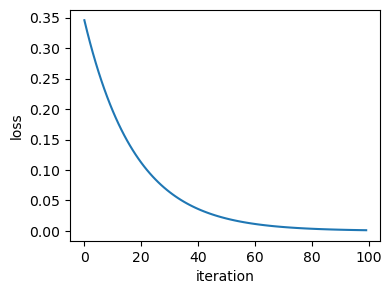

In [8]:
losses=[]
for i in range(100):
    prediction = model(Bin) 

    loss = (prediction-E)**2

    print("loss = ", loss.item())
    # To minimize the loss we compute the gradient of the loss with respect to the model parameters and take a step in that direction

    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its gradients like we did before.
    with torch.no_grad():
        for param in model.parameters():
            param -= 0.01 * param.grad

    losses.append(loss.detach().numpy())

plt.figure(figsize=(4,3))
plt.plot(losses)
plt.ylabel("loss")
plt.xlabel("iteration")
plt.show()


Of course this is just one atomic configuration so it is not learning anything that is useful or transferable. 
To properly train a MLP we will use a more complex script that reads in some atomic configurations we have already generated.

## Dataset generation

We will generate a dataset of the LJ fluid using the script `generate.py`

In [9]:
!python generate.py

0 / 100000 Energy = -28.709701538085938
10000 / 100000 Energy = -261.40020751953125
20000 / 100000 Energy = -321.718505859375
30000 / 100000 Energy = -299.0693359375
40000 / 100000 Energy = -315.5178527832031
50000 / 100000 Energy = -282.527099609375
60000 / 100000 Energy = -297.0740051269531
70000 / 100000 Energy = -287.871826171875
80000 / 100000 Energy = -311.63568115234375
90000 / 100000 Energy = -231.7172393798828


## Training a MLP

The MLP we will use is in `train_mlp.py`

Take a look at the script before we run it

The NN looks like this:
```python
class NNP(torch.nn.Module):
    def __init__(self, NB, rb, w, RCUT):
        super().__init__()
        self.NB = NB # num basis functions
        self.NF1 = NF1 # num features of hidden layer 1
        self.NF2 = NF2 # num features of hidden layer 2
        self.rb = rb   # vector of the location of the Gaussian basis functions
        self.w  = w    # width of the Gaussian basis functions
        self.RCUT = RCUT # cut off distance

        self.NN = torch.nn.Sequential(
            torch.nn.Linear(self.NB, self.NF1, dtype=torch.get_default_dtype()),
            torch.nn.SiLU(),
            torch.nn.Linear(self.NF1, self.NF2, dtype=torch.get_default_dtype()),
            torch.nn.SiLU(),
            torch.nn.Linear(self.NF2, 1, dtype=torch.get_default_dtype()),
        )

    def forward(self, x):

        # x is batched coordinates
        # the shape of x is [N_batch, N_atoms, 2]

        # turn into radial basis features
        descriptor = make_descriptor(x, self.rb, self.w, self.RCUT)

        # the shape of descriptor is [N_batch, N_atoms, N_basis]

        # pass the descriptor through the NN
        Es = self.NN(descriptor)

        # the shape of Es is [N_batch, N_atom]
   
        # total energy is the sum of the energy of each atom
        total_E = torch.sum(Es.squeeze(dim=-1), dim=-1)

        # the shape of total_E is [N_batch]

        return total_E

```

For the model in `train_mlp.py` there are 16 radial basis functions and two hidden layers each with 64 features.
We use a batch size of 10 and run for 100 epochs

In [10]:
!python train_mlp.py

NNP(
  (NN): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): SiLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): SiLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)
Epoc  0 training loss:  469.10186767578125 , validation loss: 1159.0045166015625 validation error: 26.9140567779541
Epoc  10 training loss:  48.58818435668945 , validation loss: 250.6965789794922 validation error: 12.966121673583984
Epoc  20 training loss:  53.82604217529297 , validation loss: 80.0791244506836 validation error: 5.869262218475342
Epoc  30 training loss:  35.482757568359375 , validation loss: 58.646995544433594 validation error: 5.244212627410889
Epoc  40 training loss:  190.83990478515625 , validation loss: 72.8246078491211 validation error: 6.455076694488525
Epoc  50 training loss:  81.00228118896484 , validation loss: 64.34942626953125 validation error: 6.093245983123779
Epoc  60 training loss:  68.28651428222656 , validation loss

## Using the MLP

The script `md_with_mlp.py` will run the simulation using the model as the potential energy function

In [11]:
!python md_with_mlp.py

0 / 10000 Energy = -29.548952102661133
1000 / 10000 Energy = -204.59066772460938
2000 / 10000 Energy = -220.65914916992188
3000 / 10000 Energy = -230.699462890625
4000 / 10000 Energy = -234.0193328857422
5000 / 10000 Energy = -268.66845703125
6000 / 10000 Energy = -273.327880859375
7000 / 10000 Energy = -301.91180419921875
8000 / 10000 Energy = -303.3091125488281
9000 / 10000 Energy = -296.3617248535156


## Checking the MLP

We can check the MLP works by look at the trajectory, the script below (same as `compare_trajs.py`) will plot the pair distributions functions of the reference dataset and the MLP trajectory

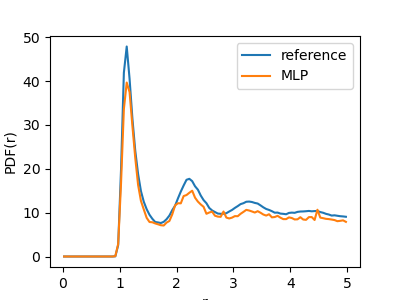

In [14]:
!python compare_trajs.py

from IPython.display import Image
Image("comparison.png")